In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import ParamTuple

np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

from src.utils.inference.posterior import PosteriorInference

### Create Environment

In [3]:
# 0. Setup
## 0.2 Setup the environment
N, M = 7,7

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 1
agent_R[N-1, M-1] = 3



# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.7
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

wall_states = [14]

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

big_small = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_true=agent_R,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

### Environment Design

In [4]:
env_design = EnvironmentDesign(base_environment=big_small, user_params=true_params)

In [5]:
candidate_environments_args = {}
candidate_environments_args["n_environments"] = 1
candidate_environments_args["generate_how"] = "random_walls"
candidate_environments_args["n_walls"] = 5


env_design.run_n_episodes(n_episodes=2,
                          bayesian_regret_how="value",
                          candidate_environments_args=candidate_environments_args)

env_design.save("big_small")

Started episode 0.
Finished episode 0.
Started episode 1.


Posterior sampling:   0%|          | 0/500 [00:00<?, ?it/s, Acceptance rate=100, step_size=0.1]

Evaluating candidate environments using value: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it, highest_regret=0.0438]

Finished episode 1.


### Inference

In [6]:
import pickle

experiment_name = os.path.join("checkpoints", "bigsmall", "22.02.2024", "15:40:28")

def load_file(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage
file_name = experiment_name
big_small_experiment = load_file(file_name)

In [7]:
pos_inference = PosteriorInference(expert_trajectories=big_small_experiment["all_observations"],
                                    resolution = 15)

### Calculate Posterior Distribution up to and including episode 1

In [8]:
pos_inference.calculate_posterior(num_episodes=2)

Calculate posterior for episode 0, e.g. the prior distribution.
Calculate posterior for episode 1.
Calculate posterior for episode 2.


### Make inference.

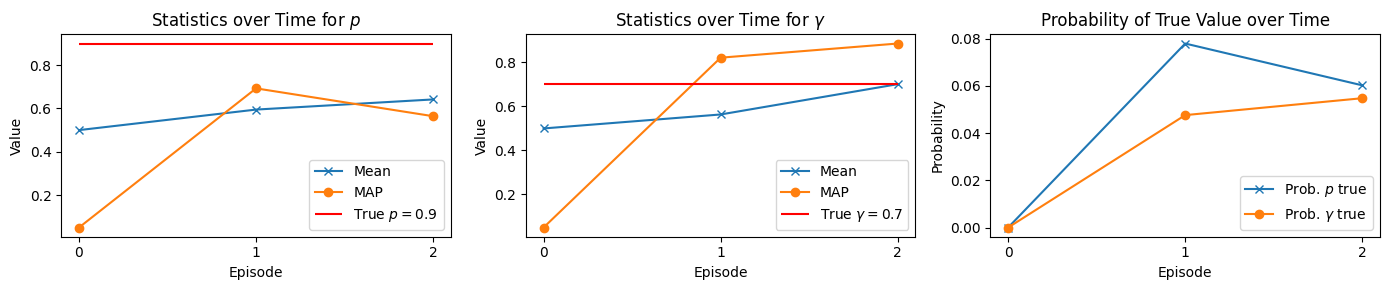

In [15]:
pos_inference.plot_statistics_over_time(episode=2, true_params=true_params)

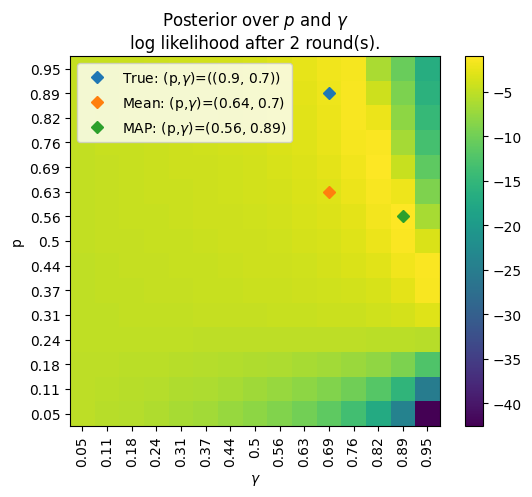

In [9]:
pos_inference.plot_posterior(episode=2,
                   param_values=true_params, show_true_prob=False)